## Знакомство с GDAL/OGR Python API

In [2]:
# Импортируем сами библиотеки - просто и без изысков
from osgeo import gdal
from osgeo import ogr

In [3]:
# Открываем растр через gdal
dataset = gdal.Open('landsat/b2.tif')

In [5]:
# что внутри? Объект класса gdal.Dataset!
print (dataset)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001E0599CAB40> >


### Очень важно научиться читать интерфейс классов в документации:

https://gdal.org/python/osgeo.gdal.Dataset-class.html

In [6]:
# Начинаем извлекать основные свойства
print ('Количество столбцов в растре:')
print (dataset.RasterXSize)

print ('\nКоличество строк в растре:')
print (dataset.RasterYSize)

print ('\nКоличество каналов ("слоёв в матрице"):')
print (dataset.RasterCount)

Количество столбцов в растре:
750

Количество строк в растре:
539

Количество каналов ("слоёв в матрице"):
1


In [7]:
# Более сложные метаданные
print ('Информация о системе координат:')
print (dataset.GetProjection())

print ('\nИнформация о геопривязке:')
print (dataset.GetGeoTransform())

Информация о системе координат:
PROJCS["WGS 84 / UTM zone 20N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32620"]]

Информация о геопривязке:
(457845.0, 30.0, 0.0, -1909245.0, 0.0, -30.0)


### Стоп! А что за странная информация о геопривязке?

Это важный момент, так GDAL хранит информацию о позиционировании ваших данных в географическом пространстве (в указанной системе координат). Итак, это 6 чисел:

* 1) 457845.0 - координата X левого верхнего угла растра
* 2) 30.0 - размер/шаг одного пикселя по X
* 3) 0.0 - первый поворотный коэффициент 1 (в 99.99% случаев это 0)
* 4) -1909245.0 - координата Y левого верхнего угла растра
* 5) 0.0 - второй поворотный коэффициент 1 (в 99.99% случаев это 0)
* 6) -30.0 - размер/шаг одного пикселя по Y

Если этот список изменять, ваш растр в буквальном смысле будет перемещаться в пространстве

### Далее - доступ к самим данным

In [8]:
band_1 = dataset.GetRasterBand(1)

In [9]:
print (band_1)

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x000001E05A596BD0> >


Сходим в документацию вместе?

In [10]:
# Читаем собственно значения матрицы
band_1_data = band_1.ReadAsArray()
print (band_1_data)

[[ 8949  8805  9094 ...  9160  9199  9180]
 [ 8752  8715  8849 ...  9161  9186  9240]
 [ 8680  8750  8790 ...  9128  9174  9270]
 ...
 [10939 11152 11776 ...  9092  9135  9265]
 [11224 11863 12554 ...  9125  9165  9233]
 [11756 12722 12250 ...  9127  9048  9362]]


Вуаля! С этой матрицей можно делать что угодно

In [11]:
# что лежит в ячейке 100, 100 ?
band_1_data[100,100]

8973

In [12]:
# Срез по ячейкам - 70 столбец с 50 по 80 строки
band_1_data[50:80, 70]

array([8897, 8902, 8887, 8893, 8927, 8975, 8967, 8945, 8945, 8927, 8891,
       8955, 8960, 8941, 8886, 8802, 8796, 8833, 8861, 8910, 8930, 8921,
       8918, 8913, 8912, 8912, 8908, 8923, 8935, 8928], dtype=uint16)

In [13]:
# на самом деле эта матрица - не простая. А numpy array. Для работы с ней импортируем numpy
import numpy

In [14]:
# Теперь нам доступна огромная мощь работы с матрицами numpy
# например статистика
print ('Минимимальное значение:')
print (numpy.nanmin(band_1_data))
print ('\nМаксимальное значение:')
print (numpy.nanmax(band_1_data))
print ('\nСреднее значение:')
print (numpy.nanmean(band_1_data))

Минимимальное значение:
8542

Максимальное значение:
20799

Среднее значение:
9311.382303030303


### Далее - к векторным данным

In [15]:
countries = ogr.Open('countries/ne_110m_admin_0_countries.shp')

In [16]:
# аналогично смотрим - что это
print (countries)

<osgeo.ogr.DataSource; proxy of <Swig Object of type 'OGRDataSourceShadow *' at 0x000001E05A5969C0> >


https://gdal.org/python/osgeo.ogr.DataSource-class.html

In [17]:
# Начинаем извлекать основные свойства
print ('Количество слоёв в наборе')
print (countries.GetLayerCount())

Количество слоёв в наборе
1


Любой прочитанный набор векторных данных будет многослойным - это важная особенность OGR.

Большая часть реальных данных - однослойные. Но есть многослойные форматы - GPKG, TAB и другие

Перед продолжением работы нужно выбрать нужный слой - обычно с индексом 0, т.е. первый (или по имени).

In [18]:
countries_layer = countries.GetLayerByIndex(0)

In [19]:
# ещё раз изучим, что это за класс
print(countries_layer)

<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x000001E05BA14A80> >


In [20]:
# продолжаем извлекать свойства
print ('Название слоя')
print (countries_layer.GetName())

print ('\nТип его геометрии')
print (countries_layer.GetGeomType())
# 1 - точки
# 2 - линии
# 3 - полигоны
# 4 - мультиточки
# 5 - мультилинии
# 6 - мультиполигоны

Название слоя
ne_110m_admin_0_countries

Тип его геометрии
3


In [21]:
# Теперь смотрим на атрибуты

print ('\nСписок атрибутов и их типы:')

layer_definition = countries_layer.GetLayerDefn()
for field in range(layer_definition.GetFieldCount()):
    field_definition = layer_definition.GetFieldDefn(field)
    print ('%s (%s)' % (field_definition.name, field_definition.type))


Список атрибутов и их типы:
featurecla (4)
scalerank (0)
LABELRANK (0)
SOVEREIGNT (4)
SOV_A3 (4)
ADM0_DIF (0)
LEVEL (0)
TYPE (4)
ADMIN (4)
ADM0_A3 (4)
GEOU_DIF (0)
GEOUNIT (4)
GU_A3 (4)
SU_DIF (0)
SUBUNIT (4)
SU_A3 (4)
BRK_DIFF (0)
NAME (4)
NAME_LONG (4)
BRK_A3 (4)
BRK_NAME (4)
BRK_GROUP (4)
ABBREV (4)
POSTAL (4)
FORMAL_EN (4)
FORMAL_FR (4)
NAME_CIAWF (4)
NOTE_ADM0 (4)
NOTE_BRK (4)
NAME_SORT (4)
NAME_ALT (4)
MAPCOLOR7 (0)
MAPCOLOR8 (0)
MAPCOLOR9 (0)
MAPCOLOR13 (0)
POP_EST (12)
POP_RANK (0)
GDP_MD_EST (2)
POP_YEAR (0)
LASTCENSUS (0)
GDP_YEAR (0)
ECONOMY (4)
INCOME_GRP (4)
WIKIPEDIA (0)
FIPS_10_ (4)
ISO_A2 (4)
ISO_A3 (4)
ISO_A3_EH (4)
ISO_N3 (4)
UN_A3 (4)
WB_A2 (4)
WB_A3 (4)
WOE_ID (0)
WOE_ID_EH (0)
WOE_NOTE (4)
ADM0_A3_IS (4)
ADM0_A3_US (4)
ADM0_A3_UN (0)
ADM0_A3_WB (0)
CONTINENT (4)
REGION_UN (4)
SUBREGION (4)
REGION_WB (4)
NAME_LEN (0)
LONG_LEN (0)
ABBREV_LEN (0)
TINY (0)
HOMEPART (0)
MIN_ZOOM (2)
MIN_LABEL (2)
MAX_LABEL (2)
NE_ID (12)
WIKIDATAID (4)
NAME_AR (4)
NAME_BN (4)
NAME_DE (

In [22]:
# Переходим к объектам
# Можно брать объект по номеру
feature3 = countries_layer.GetFeature(3)
print (feature3)

<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA14D50> >


In [23]:
# либо перебирать их
for feature in countries_layer:
    # перебираем по очереди все объекты
    print (feature)

<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BCD1300> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA14D80> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA14BD0> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA14D80> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA149F0> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA14BD0> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA14C60> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA149F0> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA14BD0> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000001E05BA14B40> >
<osgeo.ogr.Feature; proxy of <Swig Objec

In [24]:
# Получаем свойства отдельного объекта
print ('Геометрия объекта:')
print (feature3.geometry())

Геометрия объекта:
MULTIPOLYGON (((-122.84 49.0000000000001,-122.97421 49.0025377777778,-124.91024 49.98456,-125.62461 50.41656,-127.43561 50.83061,-127.99276 51.71583,-127.85032 52.32961,-129.12979 52.75538,-129.30523 53.56159,-130.51497 54.28757,-130.536108952737 54.8027544767992,-130.53611 54.80278,-129.98 55.285,-130.00778 55.9158300000001,-131.70781 56.55212,-132.73042 57.69289,-133.35556 58.41028,-134.27111 58.8611100000001,-134.945 59.2705600000001,-135.47583 59.78778,-136.47972 59.46389,-137.4525 58.905,-138.34089 59.56211,-139.039 60.0,-140.013 60.27682,-140.99778 60.30639,-140.9925 66.00003,-140.986 69.712,-140.985987610376 69.7119983995264,-139.12052 69.47102,-137.54636 68.99002,-136.50358 68.89804,-135.62576 69.31512,-134.41464 69.62743,-132.92925 69.50534,-131.43136 69.94451,-129.79471 70.19369,-129.10773 69.77927,-128.36156 70.01286,-128.13817 70.48384,-127.44712 70.37721,-125.75632 69.48058,-124.42483 70.1584,-124.28968 69.39969,-123.06108 69.56372,-122.6835 69.85553,-12

In [25]:
print ('Примеры производных от геометрии')
print ('Площадь:')
print (feature3.geometry().Area())
print ('Центральная точка:')
print (feature3.geometry().Centroid())

Примеры производных от геометрии
Площадь:
1712.9952276493761
Центральная точка:
POINT (-98.1423813720971 61.469076145349)


Площадь считается в системе координат набора данных!

In [53]:
# Получаем значение конкретного атрибута
print ('Название страны')
print (feature3['NAME'])

print ('\nЧисленность населения')
print (feature3['POP_EST'])

Название страны
Canada

Численность населения
35623680


In [58]:
# Простой кейс - напечатаем все страны с типом экономики 6. Developing region и заодно будем выводить их площади

for feature in countries_layer:
    if feature['ECONOMY'] == '6. Developing region':
        print ('%s: %s' % (feature['NAME'], feature.geometry().Area()))

Fiji: 1.6395109959007934
Kazakhstan: 330.58682220216724
Uzbekistan: 49.95882065618098
Papua New Guinea: 37.99109078303418
Sudan: 156.4445432974347
Dominican Rep.: 4.129206498675549
Bahamas: 1.3997566129500072
Fr. S. Antarctic Lands: 1.4329281249999921
Colombia: 93.94515545286522
Panama: 6.181282787115016
Nicaragua: 10.788943117624404
Honduras: 9.55461633275777
El Salvador: 1.7460878125187866
Guatemala: 9.22847308622541
Belize: 1.8726033593745157
Guyana: 17.11077946532711
Suriname: 11.751504294909749
Ecuador: 20.382425473876896
Puerto Rico: 0.7880091615998641
Jamaica: 1.0639786634175346
Botswana: 51.83766988185898
Namibia: 72.33595289473432
Cameroon: 37.60670718791081
Ghana: 19.97389944311408
Côte d'Ivoire: 27.032682464703214
Congo: 27.620749097832284
Gabon: 21.899229762601365
eSwatini: 1.6399831040728152
Lebanon: 0.9838099266088278
Palestine: 0.4803135557871201
Tunisia: 15.285951996254514
Algeria: 213.60277173919116
Jordan: 8.439170861257212
United Arab Emirates: 7.095047438395267
Qata

### Примеры простых задач и их разбор

1. Получить тип геометрии и список атрибутов слоя городов мира (populated_places/ne_110m_populated_places.shp)
2. Вывести на экран список городов мира с населением больше 2 000 000
3. Получить базовые метаданные растра ndvi/ndvi.tif
4. Найти значение самого яркого пикселя в растре landsat/b4.tif
5. Нарисовать такой фрагмент растра ndvi/ndvi.tif, чтобы в нём не было видно реки

1. Получить тип геометрии и список атрибутов слоя городов мира (populated_places/ne_110m_populated_places.shp)

In [6]:
import ogr
cities_ds = ogr.Open('populated_places/ne_110m_populated_places.shp')
cities_layer = cities_ds.GetLayerByIndex(0)
print ('Тип геометрии: %s' % cities_layer.GetGeomType())
layer_definition = cities_layer.GetLayerDefn()
print ('\nСписок атрибутов:')
for field in range(layer_definition.GetFieldCount()):
    field_definition = layer_definition.GetFieldDefn(field)
    print ('%s (%s)' % (field_definition.name, field_definition.type))

Тип геометрии: 1

Список атрибутов:
SCALERANK (0)
NATSCALE (0)
LABELRANK (0)
FEATURECLA (4)
NAME (4)
NAMEPAR (4)
NAMEALT (4)
DIFFASCII (0)
NAMEASCII (4)
ADM0CAP (2)
CAPIN (4)
WORLDCITY (2)
MEGACITY (0)
SOV0NAME (4)
SOV_A3 (4)
ADM0NAME (4)
ADM0_A3 (4)
ADM1NAME (4)
ISO_A2 (4)
NOTE (4)
LATITUDE (2)
LONGITUDE (2)
CHANGED (2)
NAMEDIFF (0)
DIFFNOTE (4)
POP_MAX (0)
POP_MIN (0)
POP_OTHER (0)
RANK_MAX (0)
RANK_MIN (0)
GEONAMEID (2)
MEGANAME (4)
LS_NAME (4)
LS_MATCH (0)
CHECKME (0)
MAX_POP10 (2)
MAX_POP20 (2)
MAX_POP50 (2)
MAX_POP300 (2)
MAX_POP310 (2)
MAX_NATSCA (2)
MIN_AREAKM (2)
MAX_AREAKM (2)
MIN_AREAMI (2)
MAX_AREAMI (2)
MIN_PERKM (2)
MAX_PERKM (2)
MIN_PERMI (2)
MAX_PERMI (2)
MIN_BBXMIN (2)
MAX_BBXMIN (2)
MIN_BBXMAX (2)
MAX_BBXMAX (2)
MIN_BBYMIN (2)
MAX_BBYMIN (2)
MIN_BBYMAX (2)
MAX_BBYMAX (2)
MEAN_BBXC (2)
MEAN_BBYC (2)
COMPARE (0)
GN_ASCII (4)
FEATURE_CL (4)
FEATURE_CO (4)
ADMIN1_COD (2)
GN_POP (2)
ELEVATION (2)
GTOPO30 (2)
TIMEZONE (4)
GEONAMESNO (4)
UN_FID (0)
UN_ADM0 (4)
UN_LAT (2)
UN_

2. Вывести на экран список городов мира с населением больше 2 000 000

In [9]:
print ('Города с населением более 2 000 000:')
cities_layer.ResetReading()
for city_feature in cities_layer:
    if city_feature['POP_MAX'] > 2000000:
        print (city_feature['NAME'])

Города с населением более 2 000 000:
Tunis
Baku
Hanoi
Ankara
Sanaa
Damascus
Lisbon
Khartoum
Pyongyang
Dar es Salaam
Havana
Kuwait
Santo Domingo
Accra
Tripoli
Tel Aviv-Yafo
Abidjan
Brasília
Dhaka
Luanda
Algiers
Rangoon
San Francisco
Denver
Houston
Miami
Atlanta
Chicago
Caracas
Kiev
Tashkent
Madrid
Bangkok
Lima
Dakar
Johannesburg
Casablanca
Seoul
Manila
Monterrey
Berlin
Ürümqi
Chengdu
Ōsaka
Kinshasa
Bangalore
Athens
Baghdad
Addis Ababa
Tehran
Vancouver
Toronto
Buenos Aires
Kabul
Vienna
Melbourne
Taipei
Los Angeles
Washington, D.C.
New York
London
Istanbul
Riyadh
Cape Town
Moscow
Mexico City
Lagos
Rome
Beijing
Nairobi
Jakarta
Bogota
Cairo
Shanghai
Tokyo
Mumbai
Paris
Santiago
Kolkata
Rio de Janeiro
São Paulo
Sydney
Singapore
Hong Kong


3. Получить базовые метаданные растра ndvi/ndvi.tif

In [10]:
import gdal
gdal_ds = gdal.Open('ndvi/ndvi.tif')
print ('Количество столбцов в растре:')
print (gdal_ds.RasterXSize)

print ('\nКоличество строк в растре:')
print (gdal_ds.RasterYSize)

print ('\nКоличество каналов ("слоёв в матрице"):')
print (gdal_ds.RasterCount)

print ('Информация о системе координат:')
print (gdal_ds.GetProjection())

print ('\nИнформация о геопривязке:')
print (gdal_ds.GetGeoTransform())

Количество столбцов в растре:
930

Количество строк в растре:
904

Количество каналов ("слоёв в матрице"):
1
Информация о системе координат:
PROJCS["WGS 84 / UTM zone 20N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32620"]]

Информация о геопривязке:
(369824.0048, 29.990477008602184, 0.0, -1814147.10982, 0.0, -29.98504678097366)


4. Найти значение самого яркого пикселя в растре landsat/b4.tif

In [12]:
import numpy as np
b4_ds = gdal.Open('landsat/b4.tif')
b4_data = b4_ds.GetRasterBand(1).ReadAsArray()
print ('Самый яркий пиксель имеет значение:')
print (np.nanmax(b4_data))

Самый яркий пиксель имеет значение:
22762


5. Нарисовать такой фрагмент растра ndvi/ndvi.tif, чтобы в нём не было видно реки

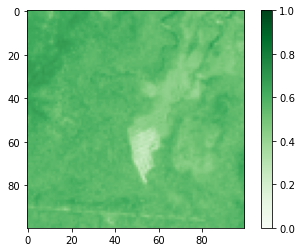

In [18]:
import matplotlib.pyplot as plt
plt.close()
ndvi_ds = gdal.Open('ndvi/ndvi.tif')
ndvi_data = ndvi_ds.GetRasterBand(1).ReadAsArray()
plt.imshow(ndvi_data[500:600,500:600], cmap='Greens', vmin=0, vmax=1)
plt.colorbar()
plt.show()